## Creating Adversial Examples and Generalization in Tensorflow

## Adversial Example

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
import numpy as np
import random
import matplotlib.pyplot as plt

use_cuda=True

#Loading Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
labels = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
#Resahping and One hot ecoding data
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

In [3]:
#Model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [4]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0198 - accuracy: 0.8625 - val_loss: 0.0060 - val_accuracy: 0.9605
Epoch 2/20
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0090 - accuracy: 0.9417 - val_loss: 0.0052 - val_accuracy: 0.9670
Epoch 3/20
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0073 - accuracy: 0.9532 - val_loss: 0.0043 - val_accuracy: 0.9715
Epoch 4/20
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0065 - accuracy: 0.9591 - val_loss: 0.0042 - val_accuracy: 0.9729
Epoch 5/20
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0057 - accuracy: 0.9633 - val_loss: 0.0038 - val_accuracy: 0.9756
Epoch 6/20
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0052 - accuracy: 0.9665 - val_loss: 0.0038 - val_accuracy: 0.9754
Epoch 7/20
60000/60000 [==========================

Model Accuracy without any training and testing on adversial examples.

In [5]:
 print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.002992545389353066, 0.9817]


The function to generate the perturbation will take in an image to apply perturbations to, and the label that correctly classifies the image. We can set up the gradients to calculate. We will be doing this using a tf.GradientTape() object. The GradientTape object keeps track of what happens to a tensor that it’s “watching,” and can automatically calculate the gradients for it. For more details on tf.GradientTape() object refer this https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

In [6]:
#Function to crate an adversial example
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

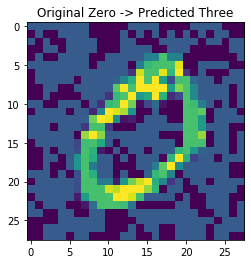

In [7]:
#Adversial Example
image = x_train[1]
image_label = y_train[1]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
#plt.imshow(image.reshape(img_rows,img_cols))
#plt.show()

#output before noise
#print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])

eps = 0.2
adversarial = image + perturbations * eps

if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
    
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))

plt.title("Original {} -> Predicted {}".format(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()], labels[model.predict(adversarial).argmax()]))
plt.show()

#output after noise
#print(labels[model.predict(adversarial).argmax()])

## Generalization

To Generalize we need an Adversial Example Generator and then train our pretrained model on them.

### Adversial Generator 

In [8]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.2
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

Accuracy of Model without any training on Adversial Examples but testing on them.

In [9]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.17828589429855346, 0.0193]


Accuracy of Model after training the pre trained model on Adversial Examples generated using the generator. And testing on the normal testing data (Not including adversial examples ). 

In [10]:
# Training the same model using adversail generator
# We can either train the model directly on the generator or pre-generate a dataset of adversarial images to fit on. Training the model on a generator allows new images to be made on-the-fly to fool the model, which would mean that the model would learn to adapt to more complex images, and become more robust in the process. Despite these benefits, this method requires significantly more computing power, and for the sake of this tutorial, we are going to pre-generate a dataset of adversarial images.
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))


Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 132us/sample - loss: 0.0162 - accuracy: 0.9068 - val_loss: 0.0146 - val_accuracy: 0.9185
Epoch 2/10
20000/20000 [==============================] - 3s 128us/sample - loss: 2.3013e-04 - accuracy: 0.9986 - val_loss: 0.0146 - val_accuracy: 0.9181
Epoch 3/10
20000/20000 [==============================] - 3s 133us/sample - loss: 1.2142e-04 - accuracy: 0.9994 - val_loss: 0.0144 - val_accuracy: 0.9193
Epoch 4/10
20000/20000 [==============================] - 3s 139us/sample - loss: 1.2622e-04 - accuracy: 0.9993 - val_loss: 0.0149 - val_accuracy: 0.9166
Epoch 5/10
20000/20000 [==============================] - 3s 131us/sample - loss: 9.2175e-05 - accuracy: 0.9995 - val_loss: 0.0148 - val_accuracy: 0.9167
Epoch 6/10
20000/20000 [==============================] - 3s 136us/sample - loss: 1.1327e-04 - accuracy: 0.9993 - val_loss: 0.0210 - val_accuracy: 0.8850
Epoch 7/10
20000/20000 [======

Although there is a noticeable drop in accuracy when evaluated on regular images, the defended model performs incredibly on the images that once fooled it. Although the model can defeat the images that used to fool it, we can still generate new images based on its weaknesses.